# 📊 삼성전자·SK하이닉스 주가 분석 실습 노트북

이 노트북은 **yfinance**로 가져온 최근 1년치 데이터를 사용해:

- 거래량 0 제거 및 결측치 보간  
- 5일·20일 이동평균 & 볼린저 밴드 계산  
- 거래량 상위 5일 & 평균 거래량  
- 일간 수익률 및 연간 변동성  
- 종목 간 수익률 상관관계 히트맵  
- 볼린저 밴드 시각화  
- 계산 지표를 포함한 Excel 파일 저장

을 순차적으로 실습합니다.


In [10]:
# (최초 1회) 필요한 패키지 설치
# !pip install yfinance pandas numpy matplotlib seaborn openpyxl

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 한글 폰트 및 음수 표시 설정 (macOS: 주석 처리)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


In [25]:
# 최근 1년 데이터 범위 설정
end = datetime.today()
start = end - timedelta(days=365)

tickers = {'삼성전자':'005930.KS', 'SK하이닉스':'000660.KS'}

raw_data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start=start, end=end)
    df['종목'] = name
    raw_data[name] = df
    print(f"{name} 데이터 shape:", df.shape)

# 멀티인덱스로 결합
price_df = pd.concat(raw_data).reset_index().set_index(['종목','Date'])
price_df.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


삼성전자 데이터 shape: (243, 6)
SK하이닉스 데이터 shape: (243, 6)


Price           level_0         Close          High           Low  \
Ticker                      005930.KS     005930.KS     005930.KS   
종목   Date                                                           
삼성전자 2024-04-29    삼성전자  75419.109375  76304.079368  74927.459379   
     2024-04-30    삼성전자  76205.757812  77189.057913  75320.787722   
     2024-05-02    삼성전자  76697.406250  77287.386298  76009.096194   
     2024-05-03    삼성전자  76304.085938  77680.706045  76205.755930   
     2024-05-07    삼성전자  79942.304688  79942.304688  78074.034344   

Price                    Open      Volume     Close      High       Low  \
Ticker              005930.KS   005930.KS 000660.KS 000660.KS 000660.KS   
종목   Date                                                                 
삼성전자 2024-04-29  76107.419369  14664474.0       NaN       NaN       NaN   
     2024-04-30  75714.107762  19007007.0       NaN       NaN       NaN   
     2024-05-02  76304.086218  18900640.0       NaN       NaN       NaN   
     2024-05-03  77680.706045  13151889.0       NaN       NaN       NaN   
     2024-05-07  78270.694380  26238868.0       NaN       NaN       NaN   

Price                Open    Volume  
Ticker          000660.KS 000660.KS  
종목   Date                            
삼성전자 2024-04-29       NaN       NaN  
     2024-04-30       NaN       NaN  
     2024-05-02       NaN       NaN  
     2024-05-03       NaN       NaN  
     2024-05-07       NaN       NaN

In [26]:
# ① 거래량 0 제거 ② 결측치는 직전값으로 보간
cleaned = (
    price_df[price_df['Volume'] != 0]
    .groupby(level=0)
    .apply(lambda df: df.ffill())
)

print("정제 후 데이터 shape:", cleaned.shape)
cleaned.head()


정제 후 데이터 shape: (486, 11)


C:\Users\student\AppData\Local\Temp\ipykernel_3676\3373961595.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda df: df.ffill())


Price                    level_0     Close      High       Low      Open  \
Ticker                           005930.KS 005930.KS 005930.KS 005930.KS   
종목     종목     Date                                                         
SK하이닉스 SK하이닉스 2024-04-29     NaN       NaN       NaN       NaN       NaN   
              2024-04-30     NaN       NaN       NaN       NaN       NaN   
              2024-05-02     NaN       NaN       NaN       NaN       NaN   
              2024-05-03     NaN       NaN       NaN       NaN       NaN   
              2024-05-07     NaN       NaN       NaN       NaN       NaN   

Price                       Volume          Close           High  \
Ticker                   005930.KS      000660.KS      000660.KS   
종목     종목     Date                                                 
SK하이닉스 SK하이닉스 2024-04-29       NaN  175386.000000  179872.850483   
              2024-04-30       NaN  173690.968750  178476.942631   
              2024-05-02       NaN  173092.718750  174189.504410   
              2024-05-03       NaN  172693.890625  176981.325554   
              2024-05-07       NaN  179075.187500  180371.388746   

Price                               Low           Open     Volume  
Ticker                        000660.KS      000660.KS  000660.KS  
종목     종목     Date                                                 
SK하이닉스 SK하이닉스 2024-04-29  175086.876634  178576.649233  2892809.0  
              2024-04-30  173292.137593  175386.001166  3655060.0  
              2024-05-02  168506.160534  168506.160534  3168250.0  
              2024-05-03  172693.890625  176482.786609  2336256.0  
              2024-05-07  178776.064136  178875.771924  4349589.0

In [27]:
print("컬럼 목록:", cleaned.columns.tolist())


컬럼 목록: [('level_0', ''), ('Close', '005930.KS'), ('High', '005930.KS'), ('Low', '005930.KS'), ('Open', '005930.KS'), ('Volume', '005930.KS'), ('Close', '000660.KS'), ('High', '000660.KS'), ('Low', '000660.KS'), ('Open', '000660.KS'), ('Volume', '000660.KS')]


In [33]:
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf

# 0) 원본 데이터 불러오기
end   = datetime.today()
start = end - timedelta(days=365)
tickers = {'삼성전자':'005930.KS', 'SK하이닉스':'000660.KS'}

raw_data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start=start, end=end)
    raw_data[name] = df

# OHLCV 필드 후보
expected = {'Open','High','Low','Close','Adj Close','Volume'}

def flatten_columns(cols):
    """
    Any MultiIndex → single-level by picking the OHLCV field if present,
    or the last element of the tuple otherwise.
    """
    new = []
    for col in cols:
        if isinstance(col, tuple):
            # 뒤에서부터 expected 안의 이름을 찾아서 사용
            for x in col[::-1]:
                if x in expected:
                    new.append(x)
                    break
            else:
                new.append(col[-1])
        else:
            new.append(col)
    return new

# 지표 계산 함수
def add_indicators(df):
    df = df.copy()
    df['MA5']      = df['Close'].rolling(5).mean()
    df['MA20']     = df['Close'].rolling(20).mean()
    std20          = df['Close'].rolling(20).std()
    df['BB_upper'] = df['MA20'] + 2 * std20
    df['BB_lower'] = df['MA20'] - 2 * std20
    return df

# 1) 종목별로 따로 처리
processed = {}
for name, df in raw_data.items():
    # 1-1) 거래량=0 제거 & 직전값 보간
    df_clean = df[df['Volume'] != 0].ffill()

    # 1-2) 컬럼 flatten
    if isinstance(df_clean.columns, pd.MultiIndex):
        df_clean = df_clean.copy()
        df_clean.columns = flatten_columns(df_clean.columns)

    # 1-3) 공백 제거 & 'Adj Close'→'Close'
    df_clean.columns = df_clean.columns.str.strip()
    if 'Adj Close' in df_clean.columns and 'Close' not in df_clean.columns:
        df_clean = df_clean.rename(columns={'Adj Close':'Close'})

    # 1-4) 꼭 필요한 컬럼만 남기기 (선택)
    keep = ['Open','High','Low','Close','Volume']
    df_clean = df_clean.loc[:, df_clean.columns.isin(keep)]

    # 1-5) 지표 계산
    df_ind = add_indicators(df_clean)

    processed[name] = df_ind

# 2) 최종 합치기
ind_df = pd.concat(processed, names=['종목'])

# 3) 인덱스 이름 설정
ind_df.index.set_names(['종목','Date'], inplace=True)

# 4) 결과 확인
print(ind_df.head(10))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                        Close          High           Low          Open  \
종목   Date                                                                 
삼성전자 2024-04-29  75419.117188  76304.087272  74927.467141  76107.427253   
     2024-04-30  76205.757812  77189.057913  75320.787722  75714.107762   
     2024-05-02  76697.406250  77287.386298  76009.096194  76304.086218   
     2024-05-03  76304.093750  77680.713998  76205.763732  77680.713998   
     2024-05-07  79942.304688  79942.304688  78074.034344  78270.694380   
     2024-05-08  79942.304688  80040.634706  79155.664543  79450.654597   
     2024-05-09  78369.015625  80138.955752  78369.015625  79745.635724   
     2024-05-10  77877.367188  79745.637360  77582.377160  79057.327296   
     2024-05-13  77090.726562  78565.676688  76304.086496  78074.026646   
     2024-05-14  76992.398438  77484.048491  76599.078394  77287.388470   

                   Volume           MA5  MA20  BB_upper  BB_lower  
종목   Date                      

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
C:\Users\student\AppData\Local\Temp\ipykernel_3676\59226706.py:23: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Loc

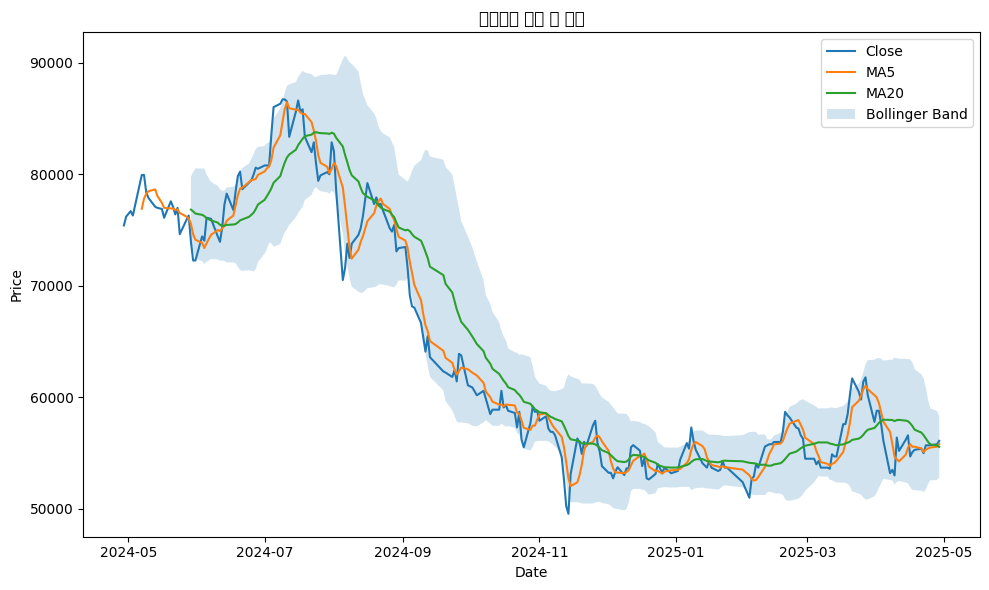

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
C:\Users\student\AppData\Local\Temp\ipykernel_3676\59226706.py:23: UserWarning: Glyph 54616 (\N{HANGUL SYLL

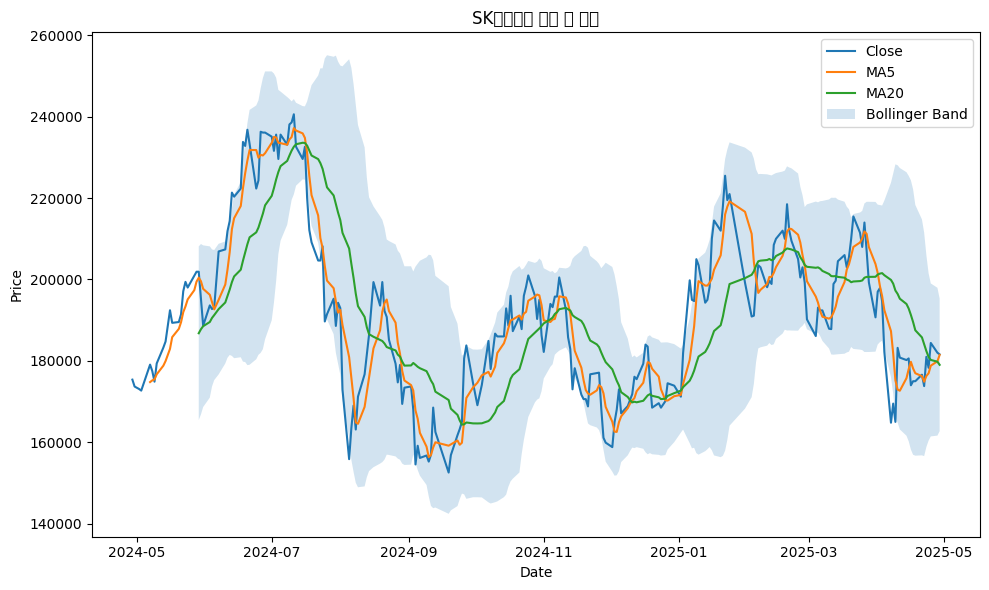

In [34]:
import matplotlib.pyplot as plt

# ind_df가 이미 정의되어 있다고 가정하고,
# 종목별로 꺼내서 시각화합니다.
tickers = ind_df.index.get_level_values('종목').unique()

for ticker in tickers:
    df = ind_df.xs(ticker, level='종목')
    
    plt.figure(figsize=(10, 6))
    # 종가, MA5, MA20
    plt.plot(df.index, df['Close'], label='Close')
    plt.plot(df.index, df['MA5'],   label='MA5')
    plt.plot(df.index, df['MA20'],  label='MA20')
    # 볼린저 밴드 영역
    plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], alpha=0.2,
                     label='Bollinger Band')

    plt.title(f"{ticker} 가격 및 지표")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [35]:
import pandas as pd

# --- 1) 종목별 평균 거래량 계산 ---
# Level=0 ('종목') 기준으로 groupby 후 mean
avg_volume = ind_df['Volume'].groupby(level='종목').mean()
print("■ 종목별 평균 거래량")
print(avg_volume)
print()

# --- 2) 종목별 거래량 상위 5일 추출 ---
# 각 종목 그룹별로 Volume 내림차순 정렬 후 상위 5개 행 가져오기
top5_volume = (
    ind_df
    .groupby(level='종목', group_keys=False)
    .apply(lambda df: df.sort_values('Volume', ascending=False).head(5))
)

print("■ 종목별 거래량 상위 5일")
print(top5_volume[['Volume']])


■ 종목별 평균 거래량
종목
SK하이닉스    4.330423e+06
삼성전자      2.138717e+07
Name: Volume, dtype: float64

■ 종목별 거래량 상위 5일
                     Volume
종목     Date                
SK하이닉스 2024-09-19  15001257
       2024-08-02  13050139
       2024-07-25  12503762
       2024-08-05  12358821
       2025-01-31  11871995
삼성전자   2024-08-05  54608790
       2024-11-13  52527995
       2024-09-19  49402713
       2024-11-14  48510715
       2024-11-18  48095234


In [36]:
# 일간 수익률 계산 및 연간 변동성(252거래일 기준) 구하기
returns = ind_df['Close'].groupby(level=0).apply(lambda x: x.pct_change())
daily_ret = returns.unstack(level=0)
annual_vol = daily_ret.std() * np.sqrt(252)

print("연간 변동성:")
display(annual_vol)
daily_ret.head()


연간 변동성:


종목
SK하이닉스    0.532435
삼성전자      0.334884
dtype: float64

종목               SK하이닉스      삼성전자
종목   Date                        
삼성전자 2024-04-29     NaN       NaN
     2024-04-30     NaN  0.010430
     2024-05-02     NaN  0.006452
     2024-05-03     NaN -0.005128
     2024-05-07     NaN  0.047680

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
c:\Users\student\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\student\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\student\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\student\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'AppleGothic' not found.
c:\Users\student\AppData\Local\Programs\Python\Python313\L

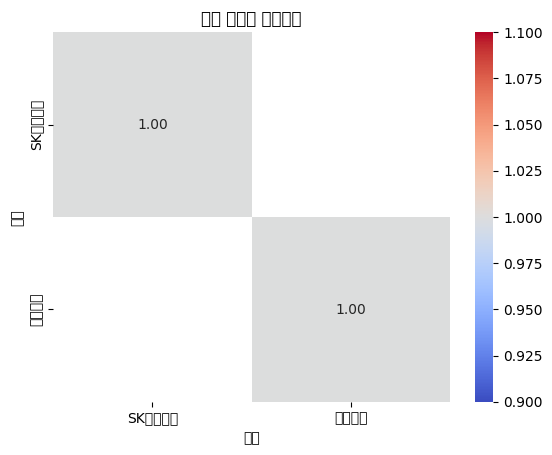

In [37]:
# 일간 수익률 상관관계 히트맵
corr = daily_ret.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('일간 수익률 상관관계')
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

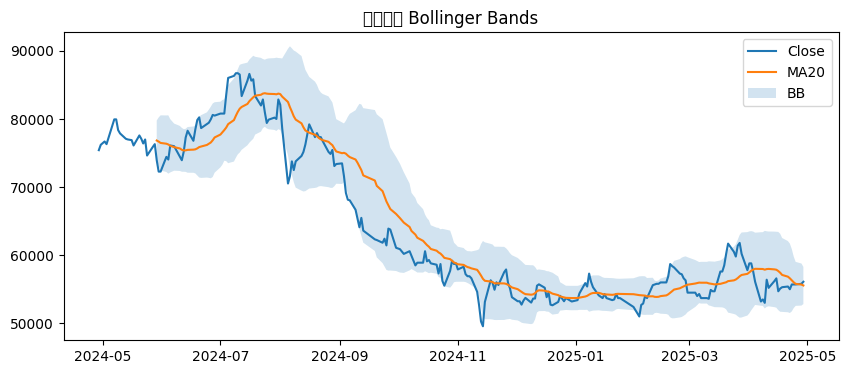

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

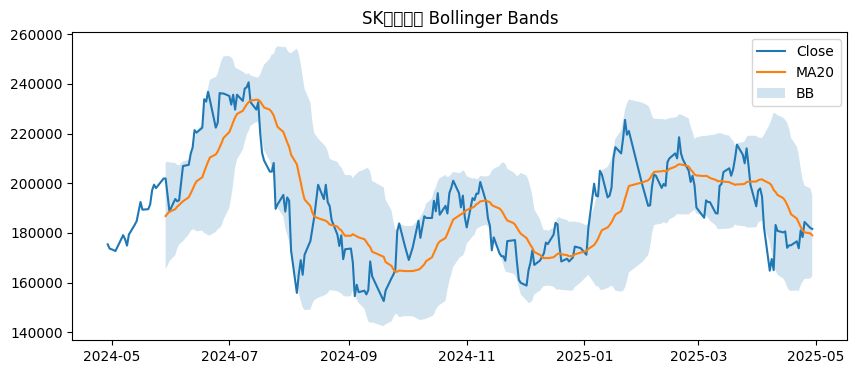

In [38]:
# 볼린저 밴드 시각화
for name in tickers:
    sub = ind_df.loc[name]
    plt.figure(figsize=(10,4))
    plt.plot(sub.index, sub['Close'], label='Close')
    plt.plot(sub.index, sub['MA20'], label='MA20')
    plt.fill_between(sub.index, sub['BB_lower'], sub['BB_upper'], alpha=0.2, label='BB')
    plt.title(f"{name} Bollinger Bands")
    plt.legend()
    plt.show()


In [ ]:
# 계산 결과를 Excel 파일로 저장
with pd.ExcelWriter('samsung_hynix_analysis.xlsx', engine='openpyxl') as writer:
    for name in tickers:
        ind_df.loc[name].to_excel(writer, sheet_name=name)
    daily_ret.to_excel(writer, sheet_name='DailyReturns')
print("Excel 파일 저장 완료 → samsung_hynix_analysis.xlsx")
